# 2. Filtering diad files into categories
- This workbook shows how to filter diad files into 3 categories, to allow easier fitting
- This data is from Devitre et al. (in review)

In [6]:
# Import useful python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
pf.__version__

'0.0.78'

## Get the folder to your files
- This loads in the information from Step1 of where you have stored things and file types

In [9]:
## This reads in the previous settings you set in Step1
meta_path, spectra_path, filetype, prefix, str_prefix, file_ext, TruPower=pf.get_settings()
# dont fit files with these strings in them
exclude_str=['Ne', 'NE', 'Si', 'nodiad', 'Spectrum', 'CRR', 'no_diad']


In [37]:
filetype

'headless_txt'

## This function finds all files in your path with the specified file format
- Specify information about your file formats here, as well as any text in filenames that you dont want to fit. 

In [36]:
import os
spectra_path = r'C:\Users\penny\Box\Berkeley_new\DiadFit_outer\Unit_tests'

Diad_Files=pf.get_files(path=spectra_path, file_ext=file_ext, exclude_str=exclude_str)
print(Diad_Files)
Diad_Files[0]

['23 K23_101_FID_50X.txt']


'23 K23_101_FID_50X.txt'

## Find approximate peak positions
- Tweak Scipy parameters to find the diad peaks
- Tweak these parameters to make sure Scipy 'find_peaks' gets your diad peaks for your instrument.
- Prominence: most useful parameter, required prominence of peaks
- height: Minimum height of peaks, not that useful with various background positions
- distance: Used to help with peaks that are very close to one another, smaller distance, remove peaks until keep set distance apart
- width: Minimum width of peaks

In [23]:
# Tweak parameters away from the default here
diad_id_config=pf.diad_id_config(prominence=30, width=1)
diad_id_config

diad_id_config(height=1, width=1, prominence=30, plot_figure=True, exclude_range1=None, exclude_range2=None, approx_diad2_pos=(1379, 1395), approx_diad1_pos=(1275, 1290), Diad2_window=(1349, 1425), Diad1_window=(1245, 1290), approx_diad2_pos_3peaks=(1379, 1395, 1362))

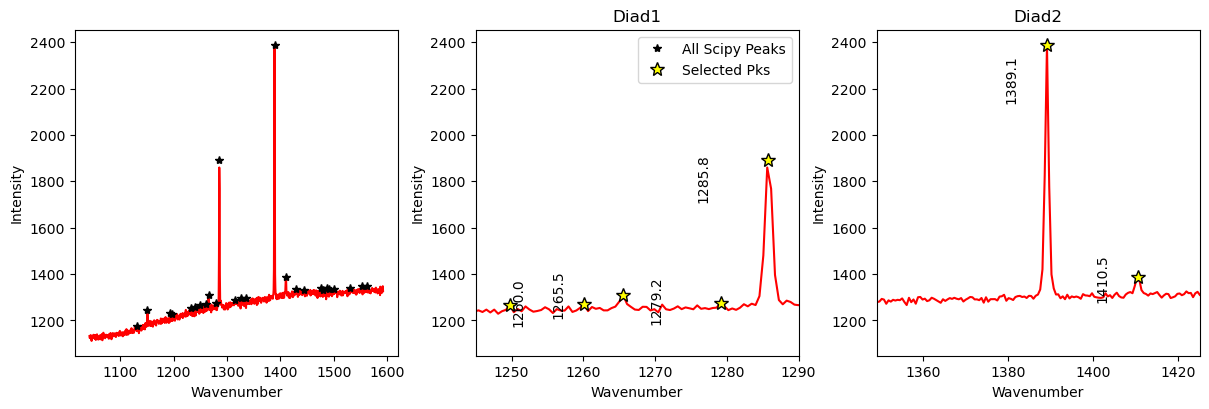

In [24]:
# Check it has found the peaks of interest. Here we are looking at the 1st file
filetype='headless_txt'
df_peaks, Diad, fig=pf.identify_diad_peaks(
config=diad_id_config, 
path=spectra_path, filename=Diad_Files[0],
filetype=filetype, plot_figure=True)


In [29]:
df_peaks['Diad2_pos'].iloc[0]

1389.08209899914

### Now you have looked at a few files and are happy with these parameters, loop over all files to get approximate fit parameters for all your diad acquisitions

In [30]:
fit_params, data_y_all=pf.loop_approx_diad_fits(spectra_path=spectra_path, config=diad_id_config, 
                       Diad_Files=Diad_Files, filetype=filetype, plot_figure=False)
fit_params.head()

100%|██████████| 1/1 [00:00<00:00, 63.21it/s]


,filename,approx_split,Diad1_pos,Diad2_pos,HB1_pos,HB2_pos,C13_pos,Diad1_abs_prom,Diad2_abs_prom,HB1_abs_prom,...,HB2_height,C13_height,Diad1_height,HB1_height,Diad1_Median_Bck,Diad2_Median_Bck,C13_HB2_abs_prom_ratio,Diad2_HB2_Valley_prom,HB1_prom/std_betweendiads,HB2_prom/std_betweendiads
0,23 K23_101_FID_50X.txt,103.288297,1285.793802,1389.082099,1265.511217,1410.470107,NaN,648.709479,1091.010726,99.795374,...,1389.047425,NaN,1892.584479,1309.045374,1243.875,1299.25,NaN,0.980548,11.744985,8.126238


## Check for duplicates now!

In [31]:
file_s=pf.extracting_filenames_generic(
    names=fit_params['filename'].reset_index(drop=True),
prefix=prefix, str_prefix=str_prefix,
   file_ext=file_ext)

good job, no duplicate file names


## Filter out spectra with Cosmic rays

### Pick a spectra to tweak first

23 K23_101_FID_50X.txt


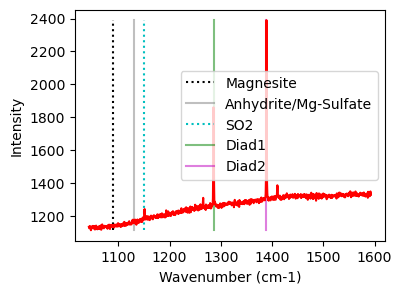

In [32]:
Diad_files=fit_params['filename']
i=0
filename_select=Diad_files.iloc[i] 
print(Diad_Files[i])
plot1=pf.plot_diad(path=spectra_path, filename=filename_select, filetype=filetype)

### Pick your other parameters

NOTE that you can also change the number of neighbors considered in the intensity factor (n),but n=1 is often the best. dynfact is the intensity factor cutoff above which pixels are considered outliers in the first pass (y axis on the first plot on the leftmost). dynfact_2 is the same, but for the second pass. The filter automatically disregards pixels that are known to be of interest (here diads, hbs and c13).


In [33]:
# This extract the peaks for the diads, HBs and C13 from fit_params_crr, essential to the CRR process.
diad_peaks=fit_params[['Diad1_pos','Diad2_pos','HB1_pos','HB2_pos','C13_pos']]

#Pick your settings
plot_rays='rays_only'#whether to plot the results or not
export_cleanspec=True #whether to export the spectra with the cosmic ray pixels removed
save_fig='all' #whether to save the figures, options are 'all' or the default 'rays_only'
dynfact=0.001 #dynamic intensity factor for the first pass (y axis on the leftmost plots)
dynfact_2=0.001#dynamic intensity factor for the second pass
n=1 # number of neighboring pixels being compared, typically 1 is ideal.

exclude_ranges=[(1100,1200)] # List of tuples containing ranges to exclude from filtering (i.e., for secondary peaks

### Run the filter on the selected spectra
- rays_found is a dataframe containing the filename and whether cosmic rays were found. spectrum is the filtered spectrum in the form of a dataframe. 
- It contains nan values where the cosmic rays are. It is NOT for fitting.

In [34]:
rays_found,spectrum=pf.cosmicray_filter.filter_singleray(path=spectra_path,
                                        exclude_ranges=exclude_ranges,filetype=filetype,
                                        Diad_files=Diad_files,i=i,diad_peaks=diad_peaks,plot_rays=plot_rays,
                                      export_cleanspec=export_cleanspec,save_fig=save_fig,dynfact=dynfact,dynfact_2=dynfact_2,n=n)


c:\users\penny\box\berkeley_new\diadfit_outer\src\DiadFit\cosmicray_filter.py:402: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '23 K23_101_FID_50X.txt' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  record.loc[file,'filename']=file
c:\users\penny\box\berkeley_new\diadfit_outer\src\DiadFit\cosmicray_filter.py:403: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  record.loc[file,'rays_present']=not all_rayswave.empty


In [35]:
rays_found['rays_present']

,filename,rays_present
23 K23_101_FID_50X.txt,23 K23_101_FID_50X.txt,False


###  Loop over all other spectra
the output of this is the data_y_all file, which contains plottable spectra and the new fit_params file with filtered spectra

In [38]:

data_y_all_crr,fit_params_crr=pf.cosmicray_filter.filter_raysinloop(Diad_files=Diad_files, spectra_path=spectra_path, 
                exclude_ranges=exclude_ranges,
                    fit_params=fit_params, diad_peaks=diad_peaks,plot_rays=plot_rays,
                    export_cleanspec=export_cleanspec,save_fig=save_fig,dynfact=dynfact,dynfact_2=dynfact_2,n=n)

  0%|          | 0/1 [00:00<?, ?it/s]c:\users\penny\box\berkeley_new\diadfit_outer\src\DiadFit\cosmicray_filter.py:402: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '23 K23_101_FID_50X.txt' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  record.loc[file,'filename']=file
c:\users\penny\box\berkeley_new\diadfit_outer\src\DiadFit\cosmicray_filter.py:403: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  record.loc[file,'rays_present']=not all_rayswave.empty
100%|██████████| 1/1 [00:00<00:00, 37.38it/s]


,filename,rays_present,approx_split,Diad1_pos,Diad2_pos,HB1_pos,HB2_pos,C13_pos,Diad1_abs_prom,Diad2_abs_prom,...,HB2_height,C13_height,Diad1_height,HB1_height,Diad1_Median_Bck,Diad2_Median_Bck,C13_HB2_abs_prom_ratio,Diad2_HB2_Valley_prom,HB1_prom/std_betweendiads,HB2_prom/std_betweendiads
0,23 K23_101_FID_50X.txt,False,103.288297,1285.793802,1389.082099,1265.511217,1410.470107,NaN,648.709479,1091.010726,...,1389.047425,NaN,1892.584479,1309.045374,1243.875,1299.25,NaN,0.980548,11.744985,8.126238


### Plot peak parameters 
- This will help you inspect clear cut offs you can use to split your diads into groups for fitting
- You can enter different x and y coordinates from the dataframe headings above
- In this example, there are no clear groups, because all the spectra are weak (see paper for definition). This means we place them all in the weak category. 

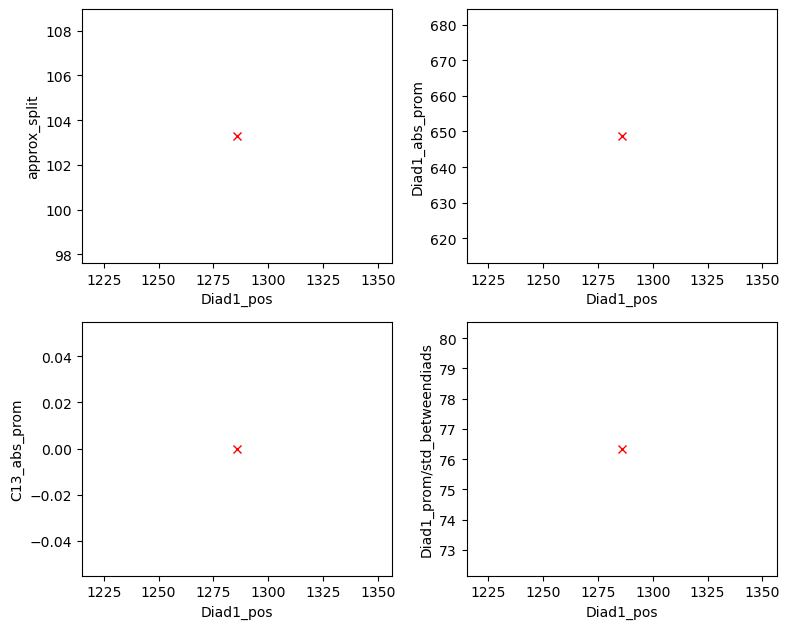

In [39]:
fig=pf.plot_peak_params(fit_params=fit_params_crr, 
                     x_param='Diad1_pos',  y1_param='approx_split',
                    y2_param='Diad1_abs_prom', y3_param='C13_abs_prom',
                    y4_param='Diad1_prom/std_betweendiads', fill_na=0)

In [19]:
fit_params_crr.head()

,filename,rays_present,approx_split,Diad1_pos,Diad2_pos,HB1_pos,HB2_pos,C13_pos,Diad1_abs_prom,Diad2_abs_prom,...,HB2_height,C13_height,Diad1_height,HB1_height,Diad1_Median_Bck,Diad2_Median_Bck,C13_HB2_abs_prom_ratio,Diad2_HB2_Valley_prom,HB1_prom/std_betweendiads,HB2_prom/std_betweendiads
0,02 K23_10_FIA_50X.txt,False,103.304796,1285.573818,1388.878613,1265.406724,1410.211625,1370.586889,1350.438271,2243.709584,...,1155.267435,1012.575258,2313.188271,1058.234775,962.750000,974.000000,5.258206,0.997310,20.093980,34.496644
1,05 K23_1_FIA_50X.txt,False,103.332294,1285.529821,1388.862114,1265.351728,1410.239124,1370.553891,1257.648999,2059.373844,...,847.759297,730.020479,1944.482342,774.689458,686.833343,687.666657,5.025325,0.998069,35.096062,62.328143
2,06 K23_1_FIA_50X_r2_longeraq.txt,False,103.315795,1285.546320,1388.862114,1265.225237,1410.244623,1370.537392,1814.736172,3016.846583,...,919.682831,748.531799,2504.486172,817.616986,689.750000,689.500000,4.626320,1.007581,63.833667,113.295804
3,08 K23_2_FIA_50X.txt,False,103.062812,1286.310766,1389.373579,NaN,NaN,NaN,43.673444,63.105423,...,NaN,NaN,737.298444,NaN,693.625000,693.250000,NaN,NaN,NaN,NaN
4,09 K23_2_FIB_50X.txt,False,103.068312,1286.052284,1389.120596,1265.621209,1410.431610,NaN,590.085495,1020.567777,...,778.082417,NaN,1288.210495,743.384188,698.125000,697.250000,NaN,0.997310,18.306456,33.172223


### Filter out ones with really bad splitting or really low diad prominence
- Here, we only take files with splitting between 101-108 (you will need to tweak this for each instrument)
- We also only take files with a prominence of diad 1 >10
- You can also choose to discard based on a specific string in the file name - excxlude exclude_str='noisy'
- None here got filtered out, but these can be helpful filters on other datasets

Keeping N=1
Discarding N=0


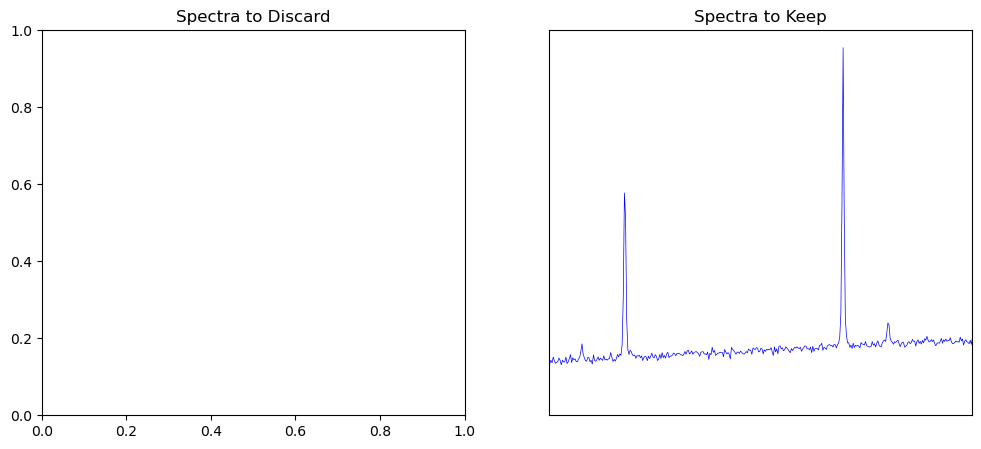

In [40]:
fit_params_filt, data_y_filt, fit_params_disc, data_y_disc=pf.filter_splitting_prominence(
fit_params=fit_params_crr, data_y_all=data_y_all, x_cord=Diad[:, 0],
splitting_limits=[101, 108], lower_diad1_prom=10, exclude_str=None)

### Now apply filters to find the weakest diads (e.g. ones you wouldnt want to fit a hotband too)
- In this case, we find the best filters are the position of Diad1 (shifts way more than Diad2), 
and where HB2 had a prominence (e.g., not nan because it wasnt found) 
- We find it also helpful to apply a filter, e.g. weak is Diad1pos<1287 or HB2 prominence nan, and  the prominence of Diad1 is <300X the standard deviation of the diad region

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([1285.29380234, 1285.39380234, 1285.49380234, 1285.59380234,
        1285.69380234, 1285.79380234, 1285.89380234, 1285.99380234,
        1286.09380234, 1286.19380234, 1286.29380234]),
 <BarContainer object of 10 artists>)

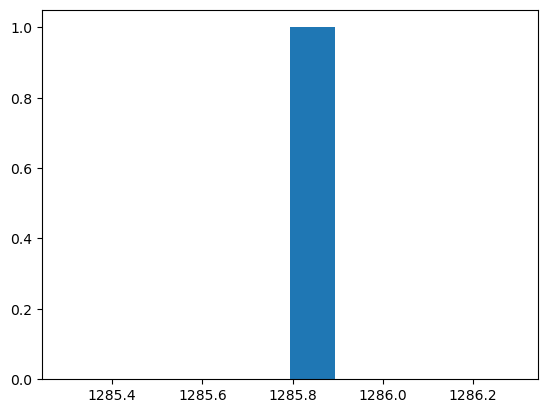

In [41]:
var='Diad1_pos'
plt.hist(fit_params_filt[var])

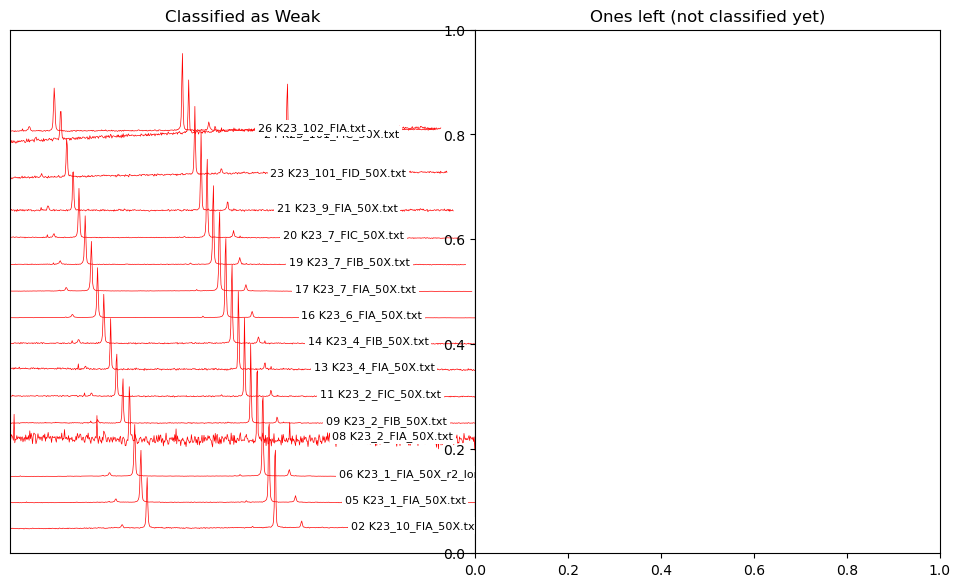

In [22]:
# Here we put spectra in the weak group if diad1 position is >1285.5 or if the av prominence of the diad relative to the standard deviation is <150

Filter2=(fit_params_filt['Av_Diad_prom/std_betweendiads']<150)
Filter3=fit_params_filt['Diad2_prom/std_betweendiads']<1100
Filter4=fit_params_filt['Diad1_pos']>1283
filter_bool=Filter4 
fit_params_Weak, fit_params_NotWeak, data_y_Weak, data_y_NotWeak=pf.identify_diad_group(
    fit_params=fit_params_filt, 
     data_y=data_y_filt, 
    x_cord=Diad[:, 0], 
    y_fig_scale=0.3,
    filter_bool=filter_bool, grp_filter='Weak')

## Seperate Medium and strong diads
- Now we need to find something that separates out strong diads from medium strength diads
- The aim here is to get diads that are sufficiently strong that you have to fit a gaussian background in addition to diads, hbs and C13 peaks. Not having to fit a gaussian background to medium density diads will save you a lot of computational time (and decrease the number of bad fits)
- In many datasets, you wont need a strong diad category. In which case, everything will stay in the 'Medium' Category
- Here, the best filter appears to be the prominence of the C13 peak, and the general elevation of the valley between diad and HB above the background outside the diad positions (Mean_Diad_HB variable). 

In [23]:
var1='C13_abs_prom'
var2='Mean_Diad_HB_Valley_prom'
filter_bool_Strong=((fit_params_NotWeak[var1]>100)
                    &(fit_params_NotWeak[var2]>100))
# Here we make a plot of these parameters to better help select the right values
if sum(filter_bool_Strong)>0:
    fig, (ax1) = plt.subplots(1, 1, figsize=(7,4))
    ax1.plot(fit_params_NotWeak[var1].loc[filter_bool_Strong],
            fit_params_NotWeak[var2].loc[filter_bool_Strong], 'xr', label='Strong')
    ax1.plot(fit_params_NotWeak[var1].loc[~filter_bool_Strong],
            fit_params_NotWeak[var2].loc[~filter_bool_Strong], 'xk', label='Medium')

    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.set_xlabel(var1)
    ax1.set_ylabel(var2)
    ax1.legend()
#This makes a plot
fit_params_Strong, fit_params_Medium, data_y_Strong, data_y_Medium=pf.identify_diad_group(
    fit_params=fit_params_NotWeak.reset_index(drop=True), 
    data_y=data_y_NotWeak,x_cord=Diad[:, 0], 
    filter_bool=filter_bool_Strong, y_fig_scale=0.2, grp_filter='Medium-Strong')

## Plot them all 

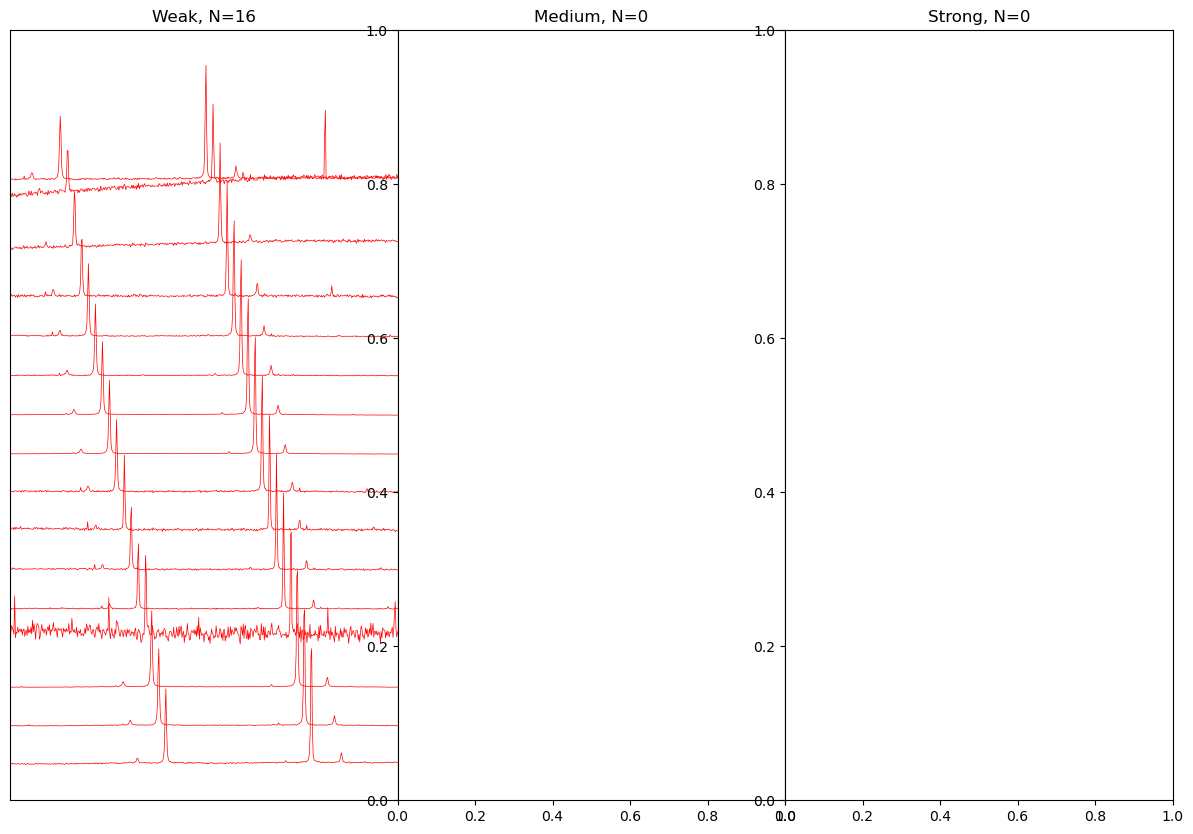

In [24]:
fig=pf.plot_diad_groups(x_cord=Diad[:, 0], Weak_np=data_y_Weak,
                 Medium_np=data_y_Medium, Strong_np=data_y_Strong,
                   y_fig_scale=0.5)

## Now lets save these lists, and we load them in another notebook

In [25]:
import joblib
joblib.dump(Diad[:, 0], 'np_x.sav')
joblib.dump(Diad[:, 1], 'np_y.sav')
joblib.dump(fit_params_Weak.reset_index(drop=True), 'Weak_df.sav')
joblib.dump(fit_params_Medium.reset_index(drop=True), 'Medium_df.sav')
joblib.dump(fit_params_Strong.reset_index(drop=True), 'Strong_df.sav')
fit_params_disc.to_excel('Discarded_df.xlsx')
